In [1]:
import numpy as np

from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier


from statistics import mean, stdev
import random
import pickle


import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('ggplot')
sn.set_style("whitegrid")
%matplotlib inline

from confused import make_confusion_matrix
from processV3 import concatenator, load_data_paths, gen_rawData
from processV3 import normaliseTestData, normaliseTrainData, segment_df, getInputVector

TrainingVector shape (3598, 360)
Label Train shape (3598,)
TestingVector shape (538, 360)
Label Test shape (538,)


In [2]:
TRAIN_FILEPATH = "./capstone_data/train/*.csv"
TEST_FILEPATH = "./capstone_data/test/*.csv"

DANCE_TO_NUM_MAP = {'dab': 0, 'jamesbond': 1, 'mermaid': 2}
NUM_TO_DANCE_MAP = {0: 'dab', 1: 'jamesbond', 2: 'mermaid'}

DANCE_MOVES = ["jamesbond", "dab", "mermaid"]


raw_train_df = concatenator(gen_rawData(load_data_paths(TRAIN_FILEPATH)))
raw_test_df = concatenator(gen_rawData(load_data_paths(TEST_FILEPATH)))
TRAIN_MAX = normaliseTrainData(raw_train_df)
normaliseTestData(raw_test_df, TRAIN_MAX)
raw_test_df["target"] = raw_test_df["dance"].map(DANCE_TO_NUM_MAP)
raw_train_df["target"] = raw_train_df["dance"].map(DANCE_TO_NUM_MAP)
test_segs, lbl_test = segment_df(raw_test_df, "target")
train_segs, lbl_train = segment_df(raw_train_df, "target")
training_X = getInputVector(train_segs)
testing_X = getInputVector(test_segs)
print("TrainingVector shape", training_X.shape)
print("Label Train shape", lbl_train.shape )
print("TestingVector shape", testing_X.shape)
print("Label Test shape", lbl_test.shape )


X_train = np.asarray(training_X)
X_test = np.asarray(testing_X)
y_train = np.asarray(lbl_train)
y_test = np.asarray(lbl_test)

TrainingVector shape (3598, 360)
Label Train shape (3598,)
TestingVector shape (538, 360)
Label Test shape (538,)


In [3]:
def fold_trainer(model, x,y, name):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    scores = []
    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x[train_index], x[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        model.fit(x_train_fold, y_train_fold)
        scores.append(model.score(x_test_fold, y_test_fold))
    print(f"-------------------------{name}--------------------------------")
    print()
    print('List of possible accuracy:', scores)
    print(f"\nMaximum Accuracy That can be obtained from {name} is:", max(scores)*100, '%')
    print('\nMinimum Accuracy:',min(scores)*100, '%')
    print('\nOverall Accuracy:',mean(scores)*100, '%')
    print('\nStandard Deviation is:', stdev(scores))
    print(f"---------------------------------------------------------------")
    print()

In [4]:
exClf = ExtraTreesClassifier(n_estimators=300, random_state=0)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo')
knn = KNeighborsClassifier()

In [5]:
vc = VotingClassifier(estimators = [('svm',poly),('exClf',exClf), ('knn', knn)], voting='hard')
fold_trainer(vc,X_train,y_train,"Voting-Classifier")

-------------------------Voting-Classifier--------------------------------

List of possible accuracy: [0.9888888888888889, 0.9972222222222222, 0.9888888888888889, 0.9944444444444445, 1.0, 0.9861111111111112, 0.9944444444444445, 0.9888888888888889, 0.9916434540389972, 0.9972144846796658]

Maximum Accuracy That can be obtained from Voting-Classifier is: 100.0 %

Minimum Accuracy: 98.61111111111111 %

Overall Accuracy: 99.27746827607552 %

Standard Deviation is: 0.004573533927860266
---------------------------------------------------------------



              precision    recall  f1-score   support

           0       0.99      0.89      0.94       182
           1       0.90      1.00      0.95       179
           2       0.99      0.99      0.99       177

    accuracy                           0.96       538
   macro avg       0.96      0.96      0.96       538
weighted avg       0.96      0.96      0.96       538



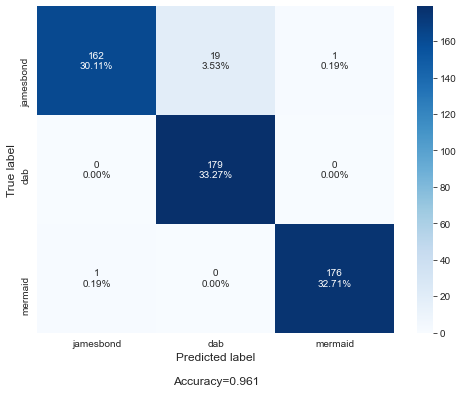

In [6]:
y_preds = vc.predict(X_test)
print(classification_report(lbl_test, y_preds))
cmt = confusion_matrix(lbl_test, y_preds)
make_confusion_matrix(cmt,categories=DANCE_MOVES, figsize=(8,6))

In [7]:
random.seed(89)
random_int = random.randint(0, len(testing_X))
print("actual output :", NUM_TO_DANCE_MAP[lbl_test[random_int]])
random_input = np.asarray(testing_X[random_int]).reshape(-1,360)
print(random_input.shape)

actual output : jamesbond
(1, 360)


In [8]:
def getPrediction(arr):
    out = vc.predict(arr)
    print(out)
    return NUM_TO_DANCE_MAP[out[0]]

getPrediction(random_input)

[1]


'jamesbond'

In [9]:
# saving
with open('testEnsemble.pkl', 'wb') as f:
    pickle.dump(vc, f)